<a href="https://colab.research.google.com/github/tanoManzo/EEG_2025/blob/main/Preproc_raws_EEG_Dreem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clean Preprocessing Script for EEG Dreem data

This script is a pre-processing script to be used on EEG Dreem data in order to do

1. Data visualization (of saved signals)
2. Epoching & visual artefact rejection
3. Power spectrum analysis with average referencing
4. Save file with best electrode only

written by Ruxandra Tivadar
(+ annoted by Nina Rimorini)


P.S. Good little helpers are included:

-Check this link for an explanation of the computations behind data pre-processing steps and a suggestion of
the order you should apply these in
https://erpinfo.org/order-of-steps

-Check this link for an interesting discussion regarding filters
https://sapienlabs.org/pitfalls-of-filtering-the-eeg-signal/

mne.tools #resampling setups

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install mne
!pip install pycrostates

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 7.8 MB/s eta 0:00:00


In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import mne
import os
import matplotlib.pyplot as plt
from mne.io import read_raw_fif, concatenate_raws
import copy
from scipy import signal
from pycrostates.cluster import ModKMeans
from pycrostates.preprocessing import extract_gfp_peaks

## 1. Data visualisation of saved signals

Opening raw data file /content/drive/MyDrive/HESSO/EEG_Project/data/EEG/test32_2_start.fif...


/tmp/ipython-input-4-1490809448.py:4: RuntimeWarning: This filename (/content/drive/MyDrive/HESSO/EEG_Project/data/EEG/test32_2_start.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_data = read_raw_fif("/content/drive/MyDrive/HESSO/EEG_Project/data/EEG/test32_2_start.fif", preload=True)


    Range : 39000 ... 69250 =    156.000 ...   277.000 secs
Ready.
Reading 0 ... 30250  =      0.000 ...   121.000 secs...
Info:
<Info | 11 non-empty values
 bads: []
 ch_names: F8, O1, O2, F7
 chs: 4 EEG
 custom_ref_applied: False
 dig: 7 items (3 Cardinal, 4 EEG)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 lowpass: 40.0 Hz
 meas_date: 2024-02-28 13:06:24 UTC
 meas_id: 4 items (dict)
 nchan: 4
 projs: []
 sfreq: 250.0 Hz
 subject_info: <subject_info | his_id: d3e90ef5-8513-41df-8d05-0bc4e1be4fb4>
>
Sensor Locations:


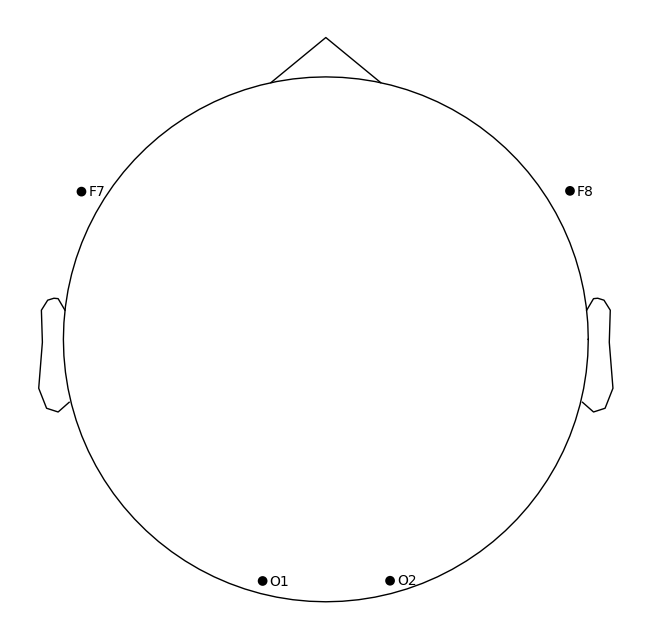

First few seconds:
Using matplotlib as 2D backend.


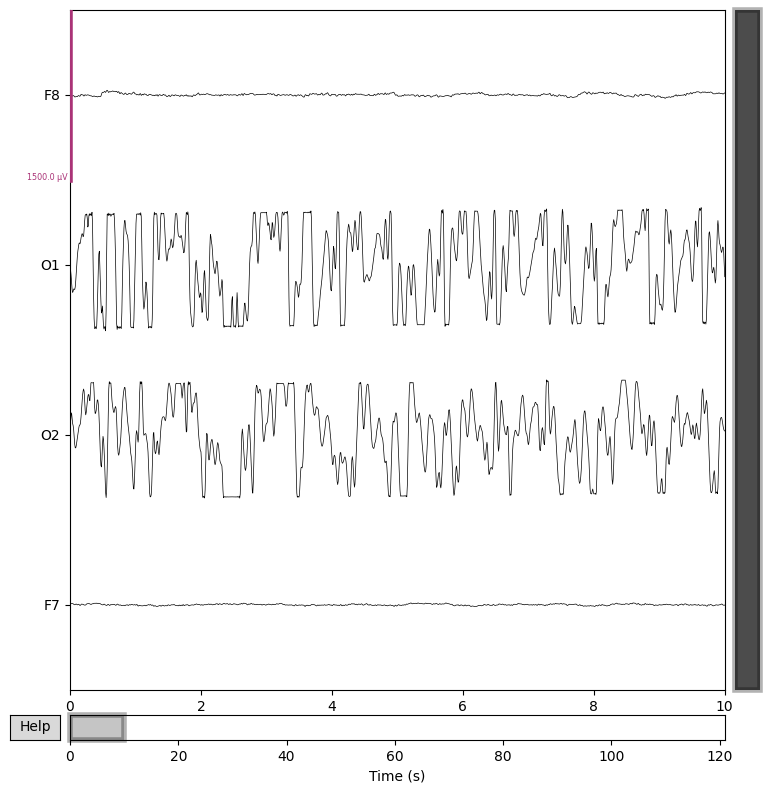

In [4]:
# Open and plot saved files

# 1 = file
raw_data = read_raw_fif("/content/drive/MyDrive/HESSO/EEG_Project/data/EEG/test32_2_start.fif", preload=True)
raw_orig = raw_data.copy()

# 2 = visualize view_data
# Print basic info
print("Info:")
print(raw_data.info)

print("Sensor Locations:")
# Plot sensor locations (if available)
raw_data.plot_sensors(show_names=True)

print("First few seconds:")
# Check first few seconds of the data
raw_data.plot(duration=10, n_channels=4, scalings={'eeg': 75e-5})
plt.close()

## 2. Basic Preprocessing

Alternative Filter Ranges for Different Analyses
Use Case	Highpass (Hz)	Lowpass (Hz)

General EEG analysis	1	30

Sleep EEG (slow waves)	0.1	30

ERP studies	0.1 – 0.5	40

Gamma analysis	1	80 – 100


## Here we need to focus on different channels' filtering (i.e., O signal and F signal)

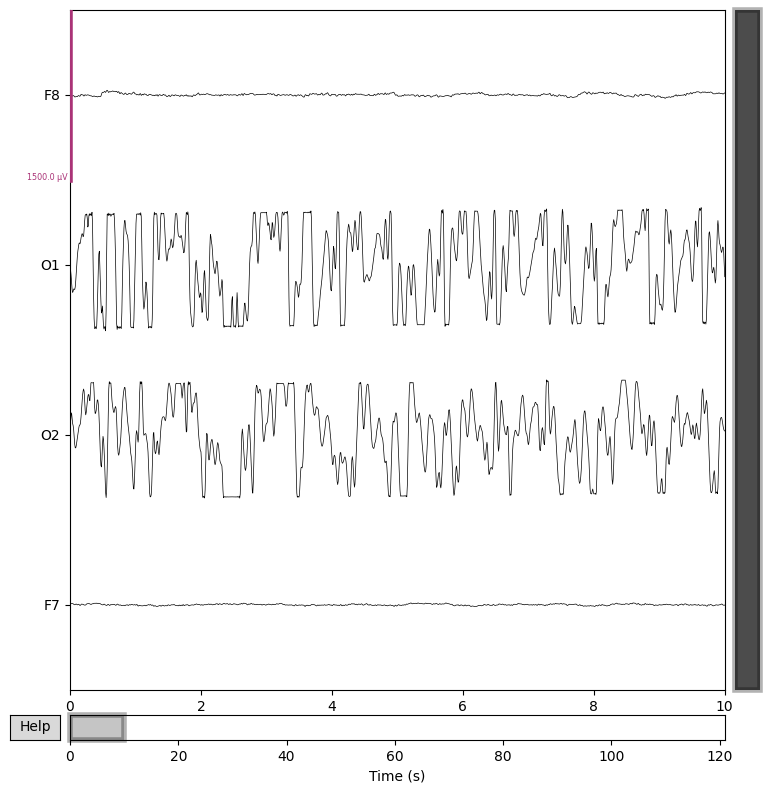

In [5]:
# Check first few seconds of the data
raw_data.plot(duration=10, n_channels=4, scalings={'eeg': 75e-5})
plt.close()

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


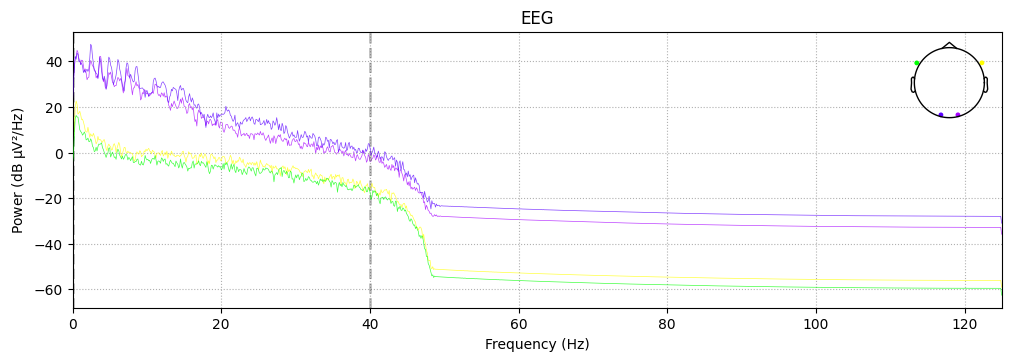

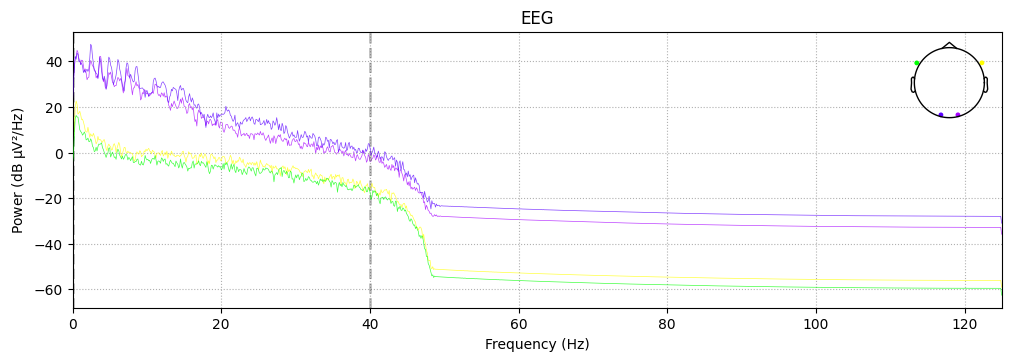

In [6]:
raw_orig.compute_psd().plot()


In [7]:
# Apply a bandpass filter between 1-30 Hz
raw_data.filter(l_freq=10.0, h_freq=30.0)

# Apply notch filter to remove 50Hz powerline noise (if necessary)
raw_data.notch_filter(freqs=50)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 331 samples (1.324 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edg

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished


<Raw | test32_2_start.fif, 4 x 30251 (121.0 s), ~958 KiB, data loaded>

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


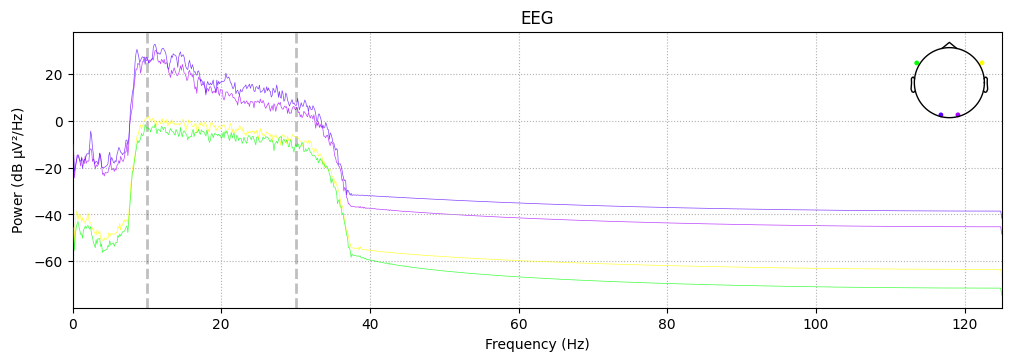

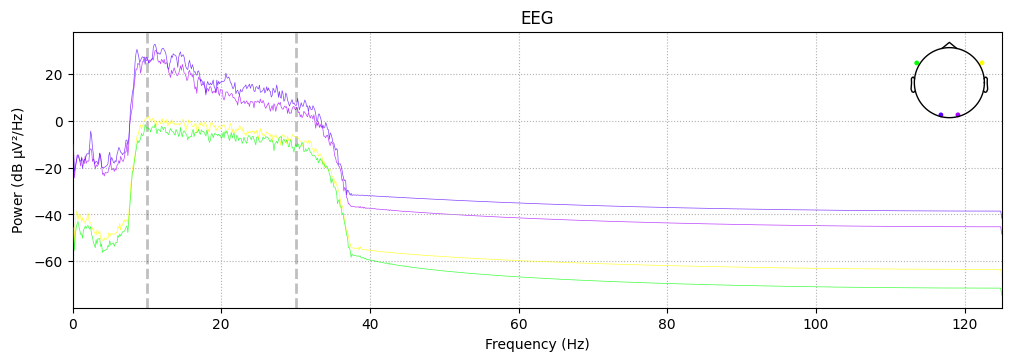

In [8]:
raw_data.compute_psd().plot()

In [9]:
import numpy as np
import scipy.stats

def compute_entropy(signal, bins=100):
    """
    Compute Shannon entropy of a signal.

    Parameters:
    - signal: 1D numpy array, EEG signal
    - bins: Number of bins for histogram estimation

    Returns:
    - entropy value
    """
    hist, _ = np.histogram(signal, bins=bins, density=True)
    hist = hist[hist > 0]  # Remove zero probabilities
    return scipy.stats.entropy(hist)

# Compute entropy for all channels
entropy_orig = [compute_entropy(raw_orig.get_data(picks=ch)[0]) for ch in raw_orig.ch_names]
entropy_preproc = [compute_entropy(raw_data.get_data(picks=ch)[0]) for ch in raw_data.ch_names]

# Print entropy values for each channel
for ch, e_orig, e_preproc in zip(raw_orig.ch_names, entropy_orig, entropy_preproc):
    print(f"Channel {ch}: Original Entropy = {e_orig:.4f}, Preprocessed Entropy = {e_preproc:.4f}")

Channel F8: Original Entropy = 3.9150, Preprocessed Entropy = 3.7987
Channel O1: Original Entropy = 4.4154, Preprocessed Entropy = 3.7060
Channel O2: Original Entropy = 4.2554, Preprocessed Entropy = 3.4652
Channel F7: Original Entropy = 3.9418, Preprocessed Entropy = 3.8935


## 4.  Detect Flat Channels/Signals

## Play with window size and threshold for different channels (i.e., O and F)

In [29]:
import numpy as np
import mne

def detect_flat_channels(raw, threshold=1e-6):
    """
    Detects channels with near-zero standard deviation (flat signals).

    Parameters:
    - raw: MNE Raw object
    - threshold: Standard deviation threshold for detecting flat channels

    Returns:
    - List of flat channels
    """
    flat_channels = []
    data, _ = raw.get_data(return_times=True)

    for i, ch_name in enumerate(raw.ch_names):
        if np.std(data[i]) < threshold:
            flat_channels.append(ch_name)

    return flat_channels


def detect_flat_segments(raw, window_size=1.5, threshold=1e-5):
    """
    Detects time periods where EEG signals are flat.

    Parameters:
    - raw: MNE Raw object
    - window_size: Time window in seconds to check for flat segments
    - threshold: Standard deviation threshold for detecting flat segments

    Returns:
    - List of flat segments (channel name, start time, end time)
    """
    sfreq = raw.info['sfreq']  # Sampling frequency
    data, times = raw.get_data(return_times=True)
    flat_segments = []

    for i, ch_name in enumerate(raw.ch_names):
        for start in range(0, len(times) - int(window_size * sfreq), int(window_size * sfreq)):
            segment = data[i, start:start + int(window_size * sfreq)]
            if np.std(segment) < threshold:
                flat_segments.append((ch_name, times[start], times[start + int(window_size * sfreq) - 1]))

    return flat_segments


# Detect and mark flat channels
flat_chs = detect_flat_channels(raw_data)
print("Flat channels detected:", flat_chs)

if flat_chs:
    raw_data.info['bads'] = flat_chs  # Mark channels as bad
else:
    print("No flat channels detected.")

# Detect flat periods
flat_periods = detect_flat_segments(raw_data)
print("Flat periods detected:", flat_periods)

raw_data.set_annotations(mne.Annotations(onset=[], duration=[], description=[]))

# Add annotations for flat segments
if flat_periods:
    onset = [seg[1] for seg in flat_periods]
    duration = [seg[2] - seg[1] for seg in flat_periods]
    description = ["BAD_flat" for _ in flat_periods]

    annotations = mne.Annotations(onset=onset, duration=duration, description=description)
    raw_data.set_annotations(annotations)
    print(f"Added {len(flat_periods)} annotations for flat segments.")
else:
    print("No flat segments detected.")


Flat channels detected: []
No flat channels detected.
Flat periods detected: [('F8', np.float64(0.0), np.float64(1.496)), ('F8', np.float64(1.5), np.float64(2.996)), ('F8', np.float64(3.0), np.float64(4.496)), ('F8', np.float64(4.5), np.float64(5.996)), ('F8', np.float64(6.0), np.float64(7.496)), ('F8', np.float64(7.5), np.float64(8.996)), ('F8', np.float64(9.0), np.float64(10.496)), ('F8', np.float64(10.5), np.float64(11.996)), ('F8', np.float64(12.0), np.float64(13.496)), ('F8', np.float64(13.5), np.float64(14.996)), ('F8', np.float64(15.0), np.float64(16.496)), ('F8', np.float64(16.5), np.float64(17.996)), ('F8', np.float64(18.0), np.float64(19.496)), ('F8', np.float64(19.5), np.float64(20.996)), ('F8', np.float64(21.0), np.float64(22.496)), ('F8', np.float64(22.5), np.float64(23.996)), ('F8', np.float64(24.0), np.float64(25.496)), ('F8', np.float64(25.5), np.float64(26.996)), ('F8', np.float64(27.0), np.float64(28.496)), ('F8', np.float64(28.5), np.float64(29.996)), ('F8', np.float

Setting 29920 of 30251 (98.91%) samples to NaN, retaining 331 (1.09%) samples.
Effective window size : 8.192 (s)
At least one good data span is shorter than n_per_seg, and will be analyzed with a shorter window than the rest of the file.
Plotting power spectral density (dB=True).


/usr/local/lib/python3.11/dist-packages/mne/time_frequency/psd.py:257: UserWarning: nperseg = 2048 is greater than input length  = 1, using nperseg = 1
  return _func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/mne/time_frequency/psd.py:257: UserWarning: nperseg = 2048 is greater than input length  = 1, using nperseg = 1
  return _func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/mne/time_frequency/psd.py:257: UserWarning: nperseg = 2048 is greater than input length  = 1, using nperseg = 1
  return _func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/mne/time_frequency/psd.py:257: UserWarning: nperseg = 2048 is greater than input length  = 1, using nperseg = 1
  return _func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/mne/time_frequency/psd.py:257: UserWarning: nperseg = 2048 is greater than input length  = 1, using nperseg = 1
  return _func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/mne/time_frequency/psd.py:257: UserWarni

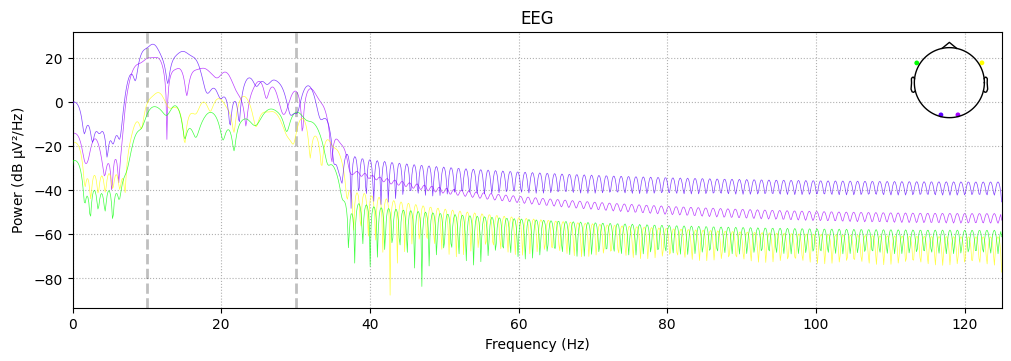

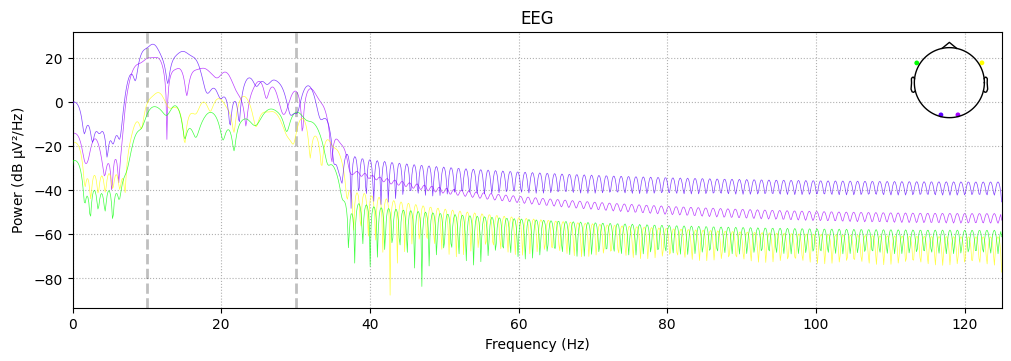

In [30]:
raw_data.compute_psd().plot()

In [37]:
print(raw_data.annotations)


<Annotations | 160 segments: BAD_flat (160)>


In [34]:
import numpy as np
import scipy.stats

def compute_entropy(signal, bins=100):
    """
    Compute Shannon entropy of a signal.

    Parameters:
    - signal: 1D numpy array, EEG signal
    - bins: Number of bins for histogram estimation

    Returns:
    - entropy value
    """
    hist, _ = np.histogram(signal, bins=bins, density=True)
    hist = hist[hist > 0]  # Remove zero probabilities
    return scipy.stats.entropy(hist)


def exclude_flat_regions(raw, ch_name):
    data = raw.get_data(picks=ch_name)[0]
    sfreq = raw.info['sfreq']
    mask = np.ones(len(data), dtype=bool)

    for onset, duration, desc in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
        if desc == 'BAD_flat':
            # Correct for raw.first_time
            start_sample = int((onset - raw.first_time) * sfreq)
            end_sample = int((onset + duration - raw.first_time) * sfreq)

            # Clamp to valid data range
            start_sample = max(0, start_sample)
            end_sample = min(len(data), end_sample)

            if start_sample < end_sample:
                mask[start_sample:end_sample] = False

    return data[mask]


entropy_orig = [compute_entropy(exclude_flat_regions(raw_orig, ch)) for ch in raw_orig.ch_names]
entropy_preproc = [compute_entropy(raw_data.get_data(picks=ch)[0]) for ch in raw_data.ch_names]
entropy_preproc_filtered = [compute_entropy(exclude_flat_regions(raw_data, ch)) for ch in raw_data.ch_names]


# Print entropy values for each channel
for ch, e_orig, e_preproc, e_fil in zip(raw_orig.ch_names, entropy_orig, entropy_preproc, entropy_preproc_filtered):
    print(f"Channel {ch}: Original Entropy = {e_orig:.4f}, After low-high Filter Entropy = {e_preproc:.4f}, After Annotation Removed = {e_fil}")

Channel F8: Original Entropy = 3.9150, After low-high Filter Entropy = 3.7987, After Annotation Removed = 4.276254974435982
Channel O1: Original Entropy = 4.4154, After low-high Filter Entropy = 3.7060, After Annotation Removed = 3.8027998677087873
Channel O2: Original Entropy = 4.2554, After low-high Filter Entropy = 3.4652, After Annotation Removed = 3.611753173110738
Channel F7: Original Entropy = 3.9418, After low-high Filter Entropy = 3.8935, After Annotation Removed = 4.01893530050061


In [ ]:
sig = raw_data.get_data(picks="F8")[0]
masked_sig = exclude_flat_regions(raw_data, "F8")

print(f"Original length: {len(sig)}, After masking: {len(masked_sig)}")


Original length: 30251, After masking: 30251


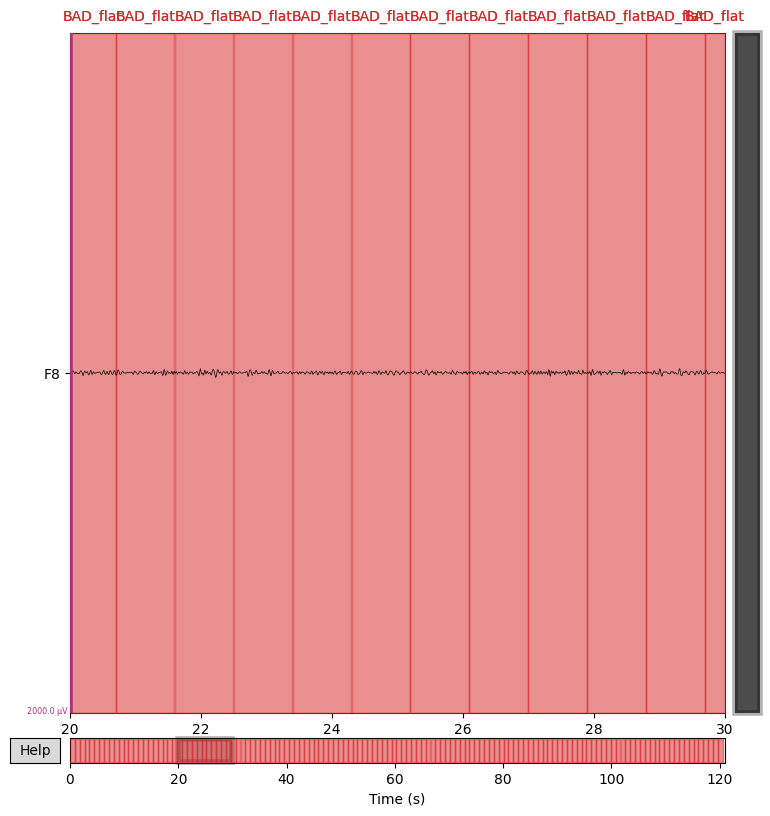

In [ ]:
# Plot EEG data with custom scalings
channel = 'F8'
raw_data.plot(picks=[channel], start=20, duration=10,scalings=100e-5)
#raw_data.plot(n_channels=len(raw_data.ch_names), scalings=scalings, title="EEG Data with Annotations")
plt.close()

### Make sure the bad signals are actually removed

In [ ]:
# interpolate bads
raw_data.interpolate_bads(reset_bads=True)

Setting channel interpolation method to {'eeg': 'spline'}.


<ipython-input-38-982977453>:2: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  pre_data.interpolate_bads(reset_bads=True)


<Raw | test32_2_start.fif, 4 x 30251 (121.0 s), ~959 KiB, data loaded>

In [ ]:
raw_data.set_eeg_reference('average', projection=True)


EEG channel type selected for re-referencing


<ipython-input-39-2101833651>:1: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  pre_data.set_eeg_reference('average', projection=True)


<Raw | test32_2_start.fif, 4 x 30251 (121.0 s), ~959 KiB, data loaded>

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


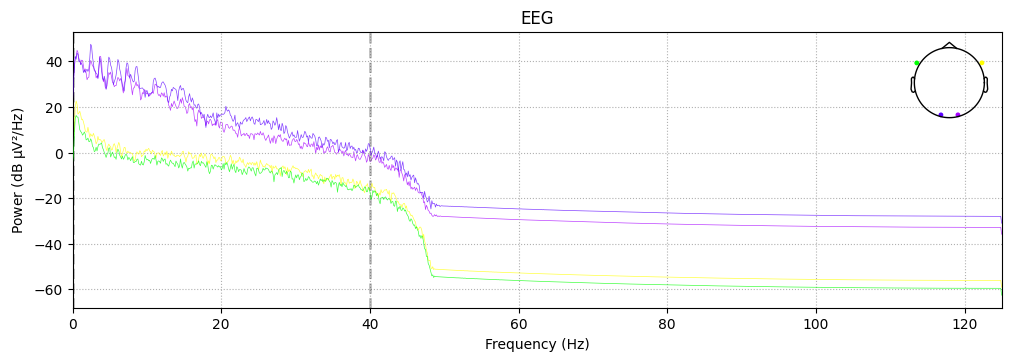

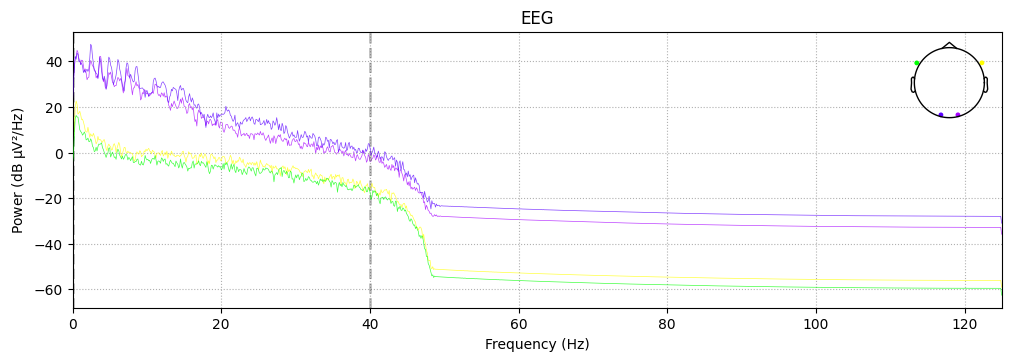

In [ ]:
raw_orig.compute_psd().plot()


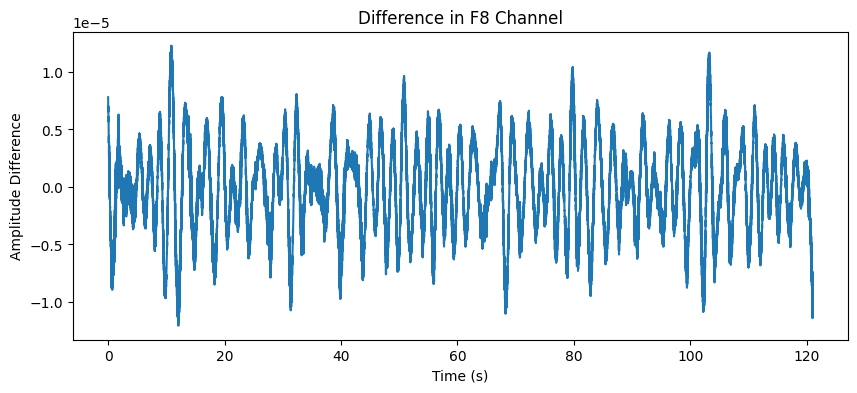

In [ ]:
# Retrieve data and times from both versions
data_orig, times = raw_orig.get_data(return_times=True)
data_preproc, _ = raw_data.get_data(return_times=True)

# Calculate the difference for a chosen channel (e.g., first channel)
channel_idx = 0
diff_signal = data_preproc[channel_idx] - data_orig[channel_idx]

# Plot the difference signal
plt.figure(figsize=(10, 4))
plt.plot(times, diff_signal)
plt.title(f"Difference in {raw_orig.ch_names[channel_idx]} Channel")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude Difference")
plt.show()


Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


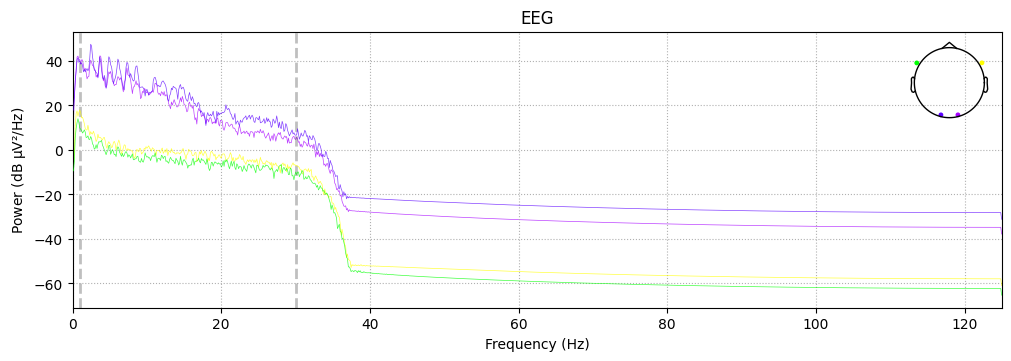

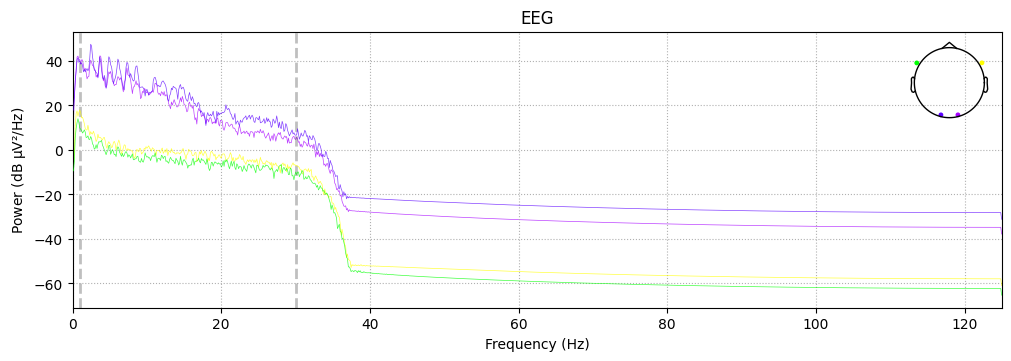

In [ ]:
raw_data.compute_psd().plot()

In [ ]:
import numpy as np
import scipy.stats

def compute_entropy(signal, bins=100):
    """
    Compute Shannon entropy of a signal.

    Parameters:
    - signal: 1D numpy array, EEG signal
    - bins: Number of bins for histogram estimation

    Returns:
    - entropy value
    """
    hist, _ = np.histogram(signal, bins=bins, density=True)
    hist = hist[hist > 0]  # Remove zero probabilities
    return scipy.stats.entropy(hist)

# Compute entropy for all channels
entropy_orig = [compute_entropy(raw_orig.get_data(picks=ch)[0]) for ch in raw_orig.ch_names]
entropy_preproc = [compute_entropy(raw_data.get_data(picks=ch)[0]) for ch in raw_data.ch_names]

# Print entropy values for each channel
for ch, e_orig, e_preproc in zip(raw_orig.ch_names, entropy_orig, entropy_preproc):
    print(f"Channel {ch}: Original Entropy = {e_orig:.4f}, Preprocessed Entropy = {e_preproc:.4f}")


Channel F8: Original Entropy = 3.9150, Preprocessed Entropy = 3.8446
Channel O1: Original Entropy = 4.4154, Preprocessed Entropy = 4.3025
Channel O2: Original Entropy = 4.2554, Preprocessed Entropy = 4.0469
Channel F7: Original Entropy = 3.9418, Preprocessed Entropy = 3.9315


In [ ]:
import numpy as np
import scipy.stats
import mne

def compute_entropy(signal, bins=100):
    """
    Compute Shannon entropy of a signal.
    Parameters:
    - signal: 1D numpy array, EEG signal
    - bins: Number of bins for histogram estimation
    Returns:
    - entropy value
    """
    hist, _ = np.histogram(signal, bins=bins, density=True)
    hist = hist[hist > 0]  # Remove zero probabilities
    return scipy.stats.entropy(hist)

def exclude_flat_regions(raw, ch_name):
    """Return signal with 'BAD_flat' annotation periods removed."""
    data = raw.get_data(picks=ch_name)[0]
    sfreq = raw.info['sfreq']
    times = raw.times

    # Create a mask of good (non-flat) time points
    mask = np.ones(len(data), dtype=bool)

    for onset, duration, desc in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
        if desc == 'BAD_flat':
            # Convert onset/duration (in seconds) to sample indices
            start_sample = int(onset * sfreq)
            end_sample = int((onset + duration) * sfreq)
            mask[start_sample:end_sample] = False

    return data[mask]  # return only the good segments

# Compute entropy excluding 'BAD_flat' segments
entropy_orig = [compute_entropy(exclude_flat_regions(raw_orig, ch)) for ch in raw_orig.ch_names]
entropy_preproc = [compute_entropy(exclude_flat_regions(raw_data, ch)) for ch in raw_data.ch_names]

# Print entropy values for each channel
for ch, e_orig, e_preproc in zip(raw_orig.ch_names, entropy_orig, entropy_preproc):
    print(f"Channel {ch}: Original Entropy = {e_orig:.4f}, Preprocessed Entropy = {e_preproc:.4f}")


Channel F8: Original Entropy = 3.9150, Preprocessed Entropy = 3.8446
Channel O1: Original Entropy = 4.4154, Preprocessed Entropy = 4.3025
Channel O2: Original Entropy = 4.2554, Preprocessed Entropy = 4.0469
Channel F7: Original Entropy = 3.9418, Preprocessed Entropy = 3.9315


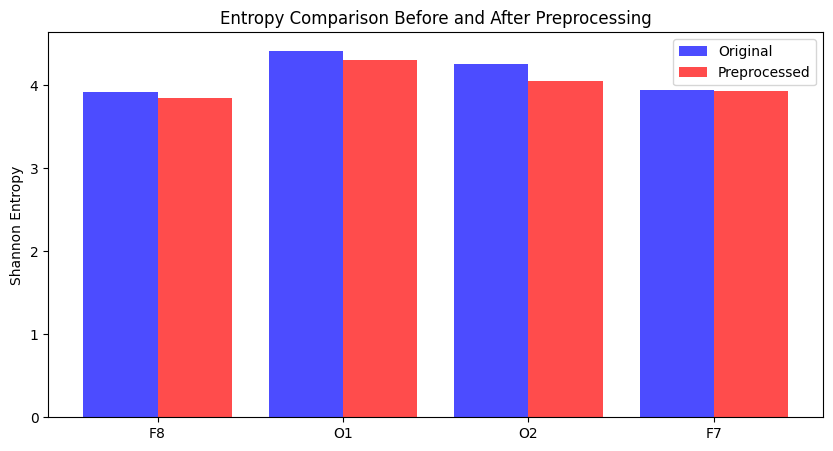

In [ ]:
import matplotlib.pyplot as plt

channels = raw_orig.ch_names
x = np.arange(len(channels))  # X-axis positions

plt.figure(figsize=(10, 5))
plt.bar(x - 0.2, entropy_orig, width=0.4, label="Original", color="blue", alpha=0.7)
plt.bar(x + 0.2, entropy_preproc, width=0.4, label="Preprocessed", color="red", alpha=0.7)
plt.xticks(x, channels)
plt.ylabel("Shannon Entropy")
plt.title("Entropy Comparison Before and After Preprocessing")
plt.legend()
plt.show()


# 2. Epoching & visual artefact rejection
## Restart Kernel & Clear Output

In [ ]:
# declare subject and session names, as well as the folder path with the EEG data
# we are now using another folder that contains the data from each subject in a separate folder
# (e.g.'(e.g.'D:\PhD\EEG_Dreem\preproc\245_1_start.fif')')

sub_s           = '247'     #change this according to subject number
ses             = '3'
t0_start        = 2017
t0_end          = 3350

#new_srate       = 500

data_path       = 'D:\\PhD\\EEG_Dreem\\data\\'#change
base_path       = data_path + 'preproc\\'+ sub_s + '_' + ses + '_'
clean_path      = data_path + 'clean\\'+ sub_s + '_' + ses + '_'
clean_best_path = data_path + 'clean\\best_electrode' + sub_s + '_' + ses + '_'


# check that the path is correctly written
print(base_path)

## LOAD & CUT 'START'
##### LOAD

In [ ]:
cond = 'start'

raw_path_start  = base_path + 'start.fif' ##### change here

# read the data
start           = read_raw_fif(raw_path_start, preload=True)

#resample to 500 Hz --> not needed because 250Hz for Dreem data
#raw.resample(new_srate, npad="auto")
#print(raw.info)

#if need to define electrodes localization (normally already done on VS code)
#montage = mne.channels.read_custom_montage('chanlocs.loc',coord_frame='head')
#montage.plot()
#start.set_montage(montage)

#Plot data
%matplotlib tk
#to activate at least once (to redo if restart kernel)
#to see all data and scroll troughout data

#%matplotlib inline
#to see one screenshot in 2D
#mne.viz.plot_raw(start, remove_dc=True)

fig=start.plot()
fig.fake_keypress("a")
#to annote bad quality signal to delete afterwards

In [ ]:
interactive_annot = start.annotations
annot_path = base_path + cond + "_saved-annotations.txt"
start.annotations.save(annot_path,overwrite=True)

for ann in start.annotations:
    descr = ann["description"]
    if descr == "BAD_":
        t_start = ann["onset"]
        t_end = ann["onset"] + ann["duration"]
        print(f"'{descr}' goes from {t_start-t0_start} to {t_end-t0_start}")

##### CUT
###### EXPLANATION CUTTING PART

- If signal is not cut from the beginning --> only keep tmax & tmax = start of first segment labelled as BAD_
- If signal is cut from the beginning --> tmin = end of first segment labelled as BAD_ & tmax = start of the following segment labelled as BAD_
- If signal is not cut up to the end --> only keep tmin & tmin = end of last segment labelled as BAD_
- If signal is cut up to the end --> can don't need to specify to cut until the end, just stop at the one before last (see example)

e.g., if we have a signal lasting 50sec:
- 'BAD_' goes from 15.00 to 17.00
- 'BAD_' goes from 23.00 to 28.00
- 'BAD_' goes from 45.00 to 50.00

We have to write the following:
- start1= start.copy().crop(tmax=15)
- start2= start.copy().crop(tmin=17, tmax=23)
- start3= start.copy().crop(tmin=28, tmax=45)

In [ ]:
start1=start.copy().crop(tmin=11.175202855103635, tmax=13.130445110635264)
start2=start.copy().crop(tmin=14.51286795146325, tmax=15.803890935046411)
start3=start.copy().crop(tmin=16.660764596716717, tmax=19.661392719486003)
start4=start.copy().crop(tmin=33.55524054246962, tmax=37.136471663097836)
start5=start.copy().crop(tmin=41.723601998572576, tmax=51.11807794432525)
start6=start.copy().crop(tmin=56.00589921484652, tmax=59.71851763026416)
start7=start.copy().crop(tmin=66.45511491791603, tmax=73.76660271234823)
start8=start.copy().crop(tmin=84.44638915060659, tmax=85.44400399714505)
start9=start.copy().crop(tmin=86.23804025695927, tmax=96.15963568879351)
start10=start.copy().crop(tmin=113.9893898643827)

'''start11=start.copy().crop(tmin=69.56095303354743, tmax=72.27438629550323)
start12=start.copy().crop(tmin=72.57714832262673, tmax=74.50589921484652)
start13=start.copy().crop(tmin=74.75153633119197, tmax=75.46716802284084)
start14=start.copy().crop(tmin=76.44400399714493, tmax=76.95241570306922)
start15=start.copy().crop(tmin=77.32372762312633, tmax=92.19234032833685)
start16=start.copy().crop(tmin=93.03778900785147, tmax=96.48970392576734)
start17=start.copy().crop(tmin=97.24946523911495, tmax=104.15536616702354)
start18=start.copy().crop(tmin=106.93163683083509, tmax=109.2353410421128)
start19=start.copy().crop(tmin=110.04651477516063, tmax=117.01284796573879)
start20=start.copy().crop(tmin=117.60670949321917, tmax=118.0178443968594)
start21=start.copy().crop(tmin=118.29193433261958, tmax=119.49107780157033)
start22=start.copy().crop(tmin=121)'''

start_cut = mne.concatenate_raws([start1,start2,start3,start4,start5,start6,start7,start8,start9,start10])#,start11,start12,start13,start14,start15,start16,start17,start18,start19,start20,start21,start22
del(start1,start2,start3,start4,start5,start6,start7,start8,start9,start10)#,start11,start12,start13,start14,start15,start16,start17,start18,start19,start20,start21,start22

In [ ]:
#to see if correctly cut (optional)
%matplotlib tk
mne.viz.plot_raw(start_cut, remove_dc=True)

###### SECOND (OR MORE) CUTS
If needed

In [ ]:
my_annot = mne.Annotations(
    onset=[0],  # in seconds
    duration=[0],  # in seconds, too
    description=["AAA"],
)
start_cut.set_annotations(my_annot)

In [ ]:
# check if first annotation added
fig=start_cut.plot()
fig.fake_keypress("a")

In [ ]:
Cannotations = start_cut.annotations
ann = Cannotations[0]
descr0 = ann["description"]
t_start= ann["onset"]
t_end = ann["onset"] + ann["duration"]

for ann in Cannotations:
    descr = ann["description"]
    if descr == "BAD_":
        start = ann["onset"]
        end = ann["onset"] + ann["duration"]
        print(f"'{descr}' goes from {start-t_start} to {end-t_end}")

# double check that annotation "AAA" is added and that the timings are ok

In [ ]:
#change the name of start_cut & start_cut2 if needed
start1=start_cut.copy().crop(tmax =74.19765881513217)
start2=start_cut.copy().crop(tmin=75.2711777301929)

'''start3=start_cut.copy().crop(tmin=57.57840456816561, tmax=74.4308219842969)
start4=start_cut.copy().crop(tmin=75.04777102069946)
start5=start_cut.copy().crop(tmin=34.332139329050676, tmax=50.39052048536759)
start6=start_cut.copy().crop(tmin=53.27532847965738)
'''
start_cut2 = mne.concatenate_raws([start1,start2]) #,start3,start4,start5,start6])
del(start1,start2) #,start3,start4,start5,start6)

In [ ]:
mne.viz.plot_raw(start_cut2)

In [ ]:
#save clean
#start_cut2 = if cut the signal twice & start_cut = if cut the signal once
start_cut.save(clean_path + "start_clean.fif",  overwrite=True)

## LOAD & CUT 'END'
##### LOAD

In [ ]:
cond = 'end'
raw_path_end      = base_path + 'end.fif' ##### change here

# read the data
end           = read_raw_fif(raw_path_end, preload=True)

#resample to 500 Hz --> not needed because 250Hz for Dreem data
#raw.resample(new_srate, npad="auto")

# si besoin de definir la localisation des electrodes
#montage = mne.channels.read_custom_montage('chanlocs.loc',coord_frame='head')
#montage.plot()
#end.set_montage(montage)

#Plot data
%matplotlib tk
#to see all data and scroll troughout data

#%matplotlib inline
#to see one screenshot in 2D

#mne.viz.plot_raw(end, remove_dc=True)

fig=end.plot()
fig.fake_keypress("a")
#to annote bad quality signal to delete afterwards

##### CUT
See 'Start' part for explanation

In [ ]:
interactive_annot=end.annotations
annot_path = base_path + cond + "_saved-annotations.txt"
end.annotations.save(annot_path,overwrite=True)

for ann in end.annotations:
    descr = ann["description"]
    if descr == "BAD_":
        tstart = ann["onset"]
        tend = ann["onset"] + ann["duration"]
        print(f"'{descr}' goes from {tstart-t0_end} to {tend-t0_end}")

In [ ]:
end1= end.copy().crop(tmin=20.146954461099085, tmax=28.206778586723885)
end2= end.copy().crop(tmin=30.554612419700334, tmax=34.49573047822969)
end3= end.copy().crop(tmin=35.44971648822275, tmax=43.31531591720204)
end4= end.copy().crop(tmin=44.2693019271951, tmax=48.16472005710193)
end5= end.copy().crop(tmin=71.4893898643827, tmax=115.68308351177711)
end6= end.copy().crop(tmin=120.84511063526043)

'''end7= end.copy().crop(tmin=48.061895217701476, tmax=60.80753233404721)
end8= end.copy().crop(tmin=64.3664142755174, tmax=71.33101042112776)
end9= end.copy().crop(tmin=71.70803483226246, tmax=92.61424982155586)
end10= end.copy().crop(tmin=95.88750720913595, tmax=98.37972362598157)
end11= end.copy().crop(tmin=102.90401655960022, tmax=108.97953518915074)
end12= end.copy().crop(tmin=112.40702983583151,tmax=114.85561741613128)
end13= end.copy().crop(tmin=115.74105353319055, tmax=121.68451106352586)
end14= end.copy().crop(tmin=65.71613247680216, tmax=67.39353376159897)
end15= end.copy().crop(tmin=68.21041998572446, tmax=69.13377244825142)
end16= end.copy().crop(tmin=69.67645910064266, tmax=74.37005567451797)
end17= end.copy().crop(tmin=75.31832919343287, tmax=75.85530335474641)
end18= end.copy().crop(tmin=77.7232879371877, tmax=80.14695446109909)
end19= end.copy().crop(tmin=86.46082740899374, tmax=87.62981698786598)
end20= end.copy().crop(tmin=88.25819100642411, tmax=89.49573047822969)
end21= end.copy().crop(tmin=90.01556716630967, tmax=91.97859300499658)
end22= end.copy().crop(tmin=92.81261670235563, tmax=94.88210877944312)
end23= end.copy().crop(tmin=97.34419243397542, tmax=102.17488879371876)
end24= end.copy().crop(tmin=103.0032000000001, tmax=108.12109122055654)
end25= end.copy().crop(tmin=111.68932705210545, tmax=114.01016873661683)
end26= end.copy().crop(tmin=117.76327537473253, tmax=121)
end27= end.copy().crop(tmin=121.24982155603129)
end28= end.copy().crop(tmin=110.68964111349123, tmax=116.18415417558845)
end29= end.copy().crop(tmin=116.54389721627376, tmax=117.15488936473957 )
end30= end.copy().crop(tmin=118.20556745182057)'''

end_cut = mne.concatenate_raws([end1,end2,end3,end4,end5,end6]) #,end7,end8,end9,end10,end11,end12,end13,end14,end15,end16,end17,end18,end19,end20,end21,end22,end23,end24,end25,end26,end27,end28,end29,end30])
del(end1,end2,end3,end4,end5,end6) #,end7,end8,end9,end10,end11,end12,end13,end14,end15,end16,end17,end18,end19,end20,end21,end22,end23,end24,end25,end26,end27,end28,end29,end30)

In [ ]:
#to see if correctly cut (optional)
%matplotlib tk
mne.viz.plot_raw(end_cut, remove_dc=True)

###### SECOND (OR MORE) CUTS
If needed

In [ ]:
my_annot = mne.Annotations(
    onset=[0],  # in seconds
    duration=[0],  # in seconds, too
    description=["AAA"],
)
end_cut.set_annotations(my_annot)

In [ ]:
# check if first annotation added
fig=end_cut.plot()
fig.fake_keypress("a")

In [ ]:
Cannotations = end_cut.annotations
ann = Cannotations[0]
descr0 = ann["description"]
t_start= ann["onset"]
t_end = ann["onset"] + ann["duration"]

for ann in Cannotations:
    descr = ann["description"]
    if descr == "BAD_":
        start = ann["onset"]
        end = ann["onset"] + ann["duration"]
        print(f"'{descr}' goes from {start-t_start} to {end-t_end}")

# double check that annotation "AAA" is added and that the timings are ok

In [ ]:
#change the name of end_cut & end_cut2 if needed
end1= end_cut.copy().crop(tmin=3.9187688793717825, tmax=18.958756316916606)
end2= end_cut.copy().crop(tmin=20.152666952177242)

'''end3= end_cut.copy().crop(tmin=78.98731877230557, tmax=107.92479543183435)
end4= end_cut.copy().crop(tmin=109.43289307637406, tmax=116.93289307637406)
end5= end_cut.copy().crop(tmin=128.22544696645264)'''

end_cut2 = mne.concatenate_raws([end1,end2]) #,end3,end4,end5])
del(end1,end2) #,end3,end4,end5)

In [ ]:
#to see if correctly cut (optional)
%matplotlib tk
mne.viz.plot_raw(end_cut2, remove_dc=True)

In [ ]:
#save clean
#end_cut2 = if cut the signal twice & end_cut = if cut the signal once
end_cut.save(clean_path + "end_clean.fif",overwrite=True)

In [ ]:
# if you forgot to close the file and need to re-specify the bad channels use this command
#end_cut.info['bads'].extend(['F8', 'O1'])

##### SELECT BAD ELECTRODES

In [ ]:
# select bad electrodes in start and apply to end
#be careful of the name (start_cut2 vs start_cut, based on the number of times it was cut)

baddies = start_cut.info['bads']
baaddies = end_cut.info['bads']
if (len(baddies) == len(baaddies)) == True:
    print('same number of electrodes')
for i in np.unique(baddies):
    print('i:', i)
    if i in baaddies:
        continue
    else:
        end_cut.info['bads'].extend([i])

for j in np.unique(baaddies):
    if j in baddies:
        continue
    else:
        start_cut.info['bads'].extend([j])

print('final electrodes end:', baaddies)
print('final electrodes start:', baddies)

In [ ]:
# use this command ".pop(-1)" to remove a bad channel that you mistakenly marked as bad
#PCI.info['bads'].pop(-1)#.extend(['C6', 'AF4', 'C5', 'AF8', 'AFp4h', 'AFp3h', 'TTP8h', 'TTP7h', 'FCC6h', 'C3', 'AF3'])

In [ ]:
# use this command if you need to completely remove channels
#start.drop_channels(['HEOGL'])
#end.drop_channels(['HEOGL'])

In [ ]:
#Save both clean files
start_cut2.save(clean_path + "start_clean.fif",  overwrite=True)
end_cut2.save(clean_path + "end_clean.fif",overwrite=True)

## 3. SPECTRAL CHECKS

### Power spectral analysis (PSD)

Plot will represent a histogram of frequency information.

Normal plot = power highest at the lowest frequencies and drops off with increasing frequency (= 1/f property)

Spikes might appear at different frequencies:
- 10Hz represent alpha band
- Other spikes might represent interference

In [ ]:
# A. If signal cleaned and cut
start = read_raw_fif(clean_path + "start_clean.fif")
end = read_raw_fif(clean_path + "end_clean.fif")

# B. If the signal not cut & raw
#start = read_raw_fif(base_path + "start.fif")

In [ ]:
from mne.time_frequency import tfr_morlet

In [ ]:
#PSD of raw clean data

%matplotlib tk
start.compute_psd(fmax=40).plot()
end.compute_psd(fmax=40).plot()

In [ ]:
# Average reference for start
start0=start.copy().load_data()
start0.set_eeg_reference('average', projection=False)

In [ ]:
# Average reference for end
end0=end.copy().load_data()
end0.set_eeg_reference('average', projection=False)

In [ ]:
start0.save(base_path + "start_preproc.fif", overwrite=True)
end0.save(base_path + "end_preproc.fif", overwrite=True)

In [ ]:
%matplotlib tk
mne.viz.plot_raw(start0, remove_dc=True)

In [ ]:
%matplotlib tk
mne.viz.plot_raw(end0, remove_dc=True)

In [ ]:
%matplotlib tk
start0.compute_psd(fmax=40).plot()
end0.compute_psd(fmax=40).plot()

In [ ]:
start.compute_psd().plot_topomap(ch_type='eeg', extrapolate='head', cmap="RdBu_r", sensors=False, normalize=True)
end.compute_psd().plot_topomap(ch_type='eeg', extrapolate='head', cmap="RdBu_r", sensors=False, normalize=True)

## 4. Save file with best electrode only

In [ ]:
sub_s           = '257'     #change this according to subject number
ses             = '3'
t0_start        = 94
t0_end          = 2519

data_path       = 'D:\\PhD\\EEG_Dreem\\data\\'#change
base_path       = data_path + 'preproc\\'+ sub_s + '_' + ses + '_'
clean_path      = data_path + 'clean\\'+ sub_s + '_' + ses + '_'
clean_best_path = data_path + 'clean\\best_electrode\\' + sub_s + '_' + ses + '_'

In [ ]:
# A. If take cleaned signal with 4 electrodes
#start = read_raw_fif(clean_path + "start_clean.fif")
#end = read_raw_fif(clean_path + "end_clean.fif")

# B. If take raw signal
startB = read_raw_fif(base_path + "start.fif", preload=True)
endB = read_raw_fif(base_path + "end.fif", preload=True)

In [ ]:
startB.drop_channels(['O2','O1','F7']) # laisse seulement ceux à enlever

##### START

In [ ]:
#Plot data
%matplotlib tk
#to activate at least once (to redo if restart kernel)
#to see all data and scroll troughout data

#%matplotlib inline
#to see one screenshot in 2D
#mne.viz.plot_raw(start, remove_dc=True)

fig=startB.plot()
fig.fake_keypress("a")
#to annote bad quality signal to delete afterwards

In [ ]:
cond = 'startB'

interactive_annot=startB.annotations
# if F8 best electrode
annot_path_F8 = base_path + cond + "_saved-annotations-F8.txt"
startB.annotations.save(annot_path_F8,overwrite=True)

# if O1 best electrode
#annot_path_O1 = base_path + cond + "_saved-annotations-O1.txt"
#startB.annotations.save(annot_path_O1,overwrite=True)

for ann in startB.annotations:
    descr = ann["description"]
    if descr == "BAD_":
        tstart = ann["onset"]
        tend = ann["onset"] + ann["duration"]
        print(f"'{descr}' goes from {tstart-t0_start} to {tend-t0_start}")

In [ ]:
start1=startB.copy().crop(tmin=10.11839200571022, tmax=16.030319486081368)
start2=startB.copy().crop(tmin=17.007155460385434, tmax=31.241681655960036)
start3=startB.copy().crop(tmin=31.870055674518213, tmax=47.71343326195574)
start4=startB.copy().crop(tmin=48.810231548893654, tmax=49.472880513918625)
start5=startB.copy().crop(tmin=50.181229407566036, tmax=58.14187009279087)
start6=startB.copy().crop(tmin=62.55762569593148, tmax=63.935906352605286)
start7=startB.copy().crop(tmin=64.49001798715204, tmax=78.48461955745896)
start8=startB.copy().crop(tmin=80.1069670235546, tmax=86.75580585296217)
start9=startB.copy().crop(tmin=87.89830406852246, tmax=91.81864325481797)
start10=startB.copy().crop(tmin=93.14965367594573, tmax=97.5934709493219)
start11=startB.copy().crop(tmin=99.4443180585296, tmax=115.05995717344757)
start12=startB.copy().crop(tmin=116.76159885795863)
'''
start13=startB.copy().crop(tmin=86.76628865096359, tmax=88.58650221270523)
start14=startB.copy().crop(tmin=89.04921399000705, tmax=95.7494652391149)
start15=startB.copy().crop(tmin=95.94940242683788, tmax=110.7188316916488)
start16=startB.copy().crop(tmin=112.25549179157747, tmax=114.53270463954323)
start17=startB.copy().crop(tmin=116.01223982869374, tmax=121)
start18=startB.copy().crop(tmin=110.74708008565312, tmax=112.63013104925062)
start19=startB.copy().crop(tmin=116.53176245538907, tmax=117.08744439685938)
start20=startB.copy().crop(tmin=118.5269921484653, tmax=119.7059243397573)
start21=startB.copy().crop(tmin=122.09279086366882, tmax=123.98286937901503)
start22=startB.copy().crop(tmin=126)
start23=startB.copy().crop(tmin=83.75185039257673, tmax=90.47495160599573)
start24=startB.copy().crop(tmin=90.7491511777302, tmax=92.2494652391149)
start25=startB.copy().crop(tmin=92.85498929336188, tmax=95.86132990720915)
start26=startB.copy().crop(tmin=97.95210164168452, tmax=104.09617016416843)
start27=startB.copy().crop(tmin=107.00382812276939, tmax=109.41035717344755)
start28=startB.copy().crop(tmin=109.75310663811564, tmax=115.63097787294794)
start29=startB.copy().crop(tmin=115.84225553176304, tmax=117.17844396859391)
start30=startB.copy().crop(tmin=117.50392576730911, tmax=118.0235546038544)
start31=startB.copy().crop(tmin=118.30906495360455, tmax=119.49107780157033)
start32=startB.copy().crop(tmin=121)'''

startB_cut = mne.concatenate_raws([start1,start2,start3,start4,start5,start6,start7,start8,start9,start10,start11,start12])#,start13,start14,start15,start16,start17,start18,start19,start20,start21,start22,start23,start24,start25,start26,start27,start28,start29,start30,start31,start32])
del(start1,start2,start3,start4,start5,start6,start7,start8,start9,start10,start11,start12)#,start13,start14,start15,start16,start17,start18,start19,start20,start21,start22,start23,start24,start25,start26,start27,start28,start29,start30,start31,start32)

In [ ]:
#to see if correctly cut (optional)
%matplotlib tk
mne.viz.plot_raw(startB_cut, remove_dc=True)

In [ ]:
#save clean with best electrode
startB_cut.save(clean_best_path + "start_best_clean.fif",  overwrite=True)

##### END

In [ ]:
endB.drop_channels(['O1','O2','F7']) # laisse seulement ceux à enlever

In [ ]:
#Plot data
%matplotlib tk
#to activate at least once (to redo if restart kernel)
#to see all data and scroll troughout data

#%matplotlib inline
#to see one screenshot in 2D
#mne.viz.plot_raw(start, remove_dc=True)

fig=endB.plot()
fig.fake_keypress("a")
#to annote bad quality signal to delete afterwards

In [ ]:
cond = 'endB'

interactive_annot=endB.annotations
# if F8 best electrode
annot_path_F8 = base_path + cond + "_saved-annotations-F8.txt"
endB.annotations.save(annot_path_F8,overwrite=True)

# if O1 best electrode
#annot_path_O1 = base_path + cond + "_saved-annotations-O1.txt"
#endB.annotations.save(annot_path_O1,overwrite=True)

for ann in endB.annotations:
    descr = ann["description"]
    if descr == "BAD_":
        tstart = ann["onset"]
        tend = ann["onset"] + ann["duration"]
        print(f"'{descr}' goes from {tstart-t0_end} to {tend-t0_end}")

In [ ]:
end1= endB.copy().crop(tmin=13.39529079229078, tmax=21.213119200570873 )
end2= endB.copy().crop(tmin=21.652981013561657, tmax=30.79610735189135)
end3= endB.copy().crop(tmin=34.00652733761581, tmax=35.33339557458976)
end4= endB.copy().crop(tmin=36.001757030692715, tmax=62.793408137044935)
end5= endB.copy().crop(tmin=67.77470035688793, tmax=84.75279257673083)
end6= endB.copy().crop(tmin=89.12856074232695, tmax=105.19265438972161)
end7= endB.copy().crop(tmin=107.63188807994266)

'''
end8= endB.copy().crop(tmin=70.04080228408293, tmax=70.91845481798714)
end9= endB.copy().crop(tmin=72.17520285510341, tmax=75.68424268379727)
end10= endB.copy().crop(tmin=76.2783417558885, tmax=78.86974161313356)
end11= endB.copy().crop(tmin=79.48669064953606, tmax=80.3243557458959)
end12= endB.copy().crop(tmin=107.24739414703754, tmax=107.76723083511797)
end13= endB.copy().crop(tmin=108.6698044254108, tmax=109.18964111349032)
end14= endB.copy().crop(tmin=109.60665296216985, tmax=110.58348893647417)
end15= endB.copy().crop(tmin=121)
end16= endB.copy().crop(tmin=99.99478829407553, tmax=102.1956676659529)
end17= endB.copy().crop(tmin=103.02397887223424, tmax=104.9013173447538)
end18= endB.copy().crop(tmin=105.52397887223424, tmax=106.57093504639533)
end19= endB.copy().crop(tmin=112.2320137044967, tmax=114.14726852248396)
end20= endB.copy().crop(tmin=117.77470035688793, tmax=120.02212705210559)
end21= endB.copy().crop(tmin=121)
end22= endB.copy().crop(tmin=92.81261670235563, tmax=94.88210877944312)
end23= endB.copy().crop(tmin=97.34419243397542, tmax=102.17488879371876)
end24= endB.copy().crop(tmin=103.0032000000001, tmax=108.12109122055654)
end25= endB.copy().crop(tmin=111.68932705210545, tmax=114.01016873661683)
end26= endB.copy().crop(tmin=117.76327537473253, tmax=121)
end27= endB.copy().crop(tmin=121.24982155603129)
end28= endB.copy().crop(tmin=110.68964111349123, tmax=116.18415417558845)
end29= endB.copy().crop(tmin=116.54389721627376, tmax=117.15488936473957)
end30= endB.copy().crop(tmin=118.20556745182057)'''

endB_cut = mne.concatenate_raws([end1,end2,end3,end4,end5,end6,end7]) #,end8,end9,end10,end11,end12,end13,end14,end15,end16,end17,end18,end19,end20,end21,end22,end23,end24,end25,end26,end27,end28,end29,end30])
del(end1,end2,end3,end4,end5,end6,end7) #,end8,end9,end10,end11,end12,end13,end14,end15,end16,end17,end18,end19,end20,end21,end22,end23,end24,end25,end26,end27,end28,end29,end30)

In [ ]:
#to see if correctly cut (optional)
%matplotlib tk
mne.viz.plot_raw(endB_cut, remove_dc=True)

In [ ]:
#save clean with best electrode
endB_cut.save(clean_best_path + "end_best_clean.fif",  overwrite=True)